# File and libraries

In [1]:
import pandas as pd
import numpy as np

filepath=r'dataset/df_ecom_2_6_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Multicategory Store"

# DSLabs functions

In [2]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [3]:
%run "data_functions.py"


dslabs_functions lodaded
data_functions loaded


# Load

In [4]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    sample=0.1
    df = df.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test = test.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train = train.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)


    
else:
# data=pd.read_csv(f"{filepath}.csv")  
# test= pd.read_csv(test_filepath)
# train= pd.read_csv(train_filepath)
# use 10% sample file when heavy processing
    df=pd.read_csv(sample_filepath)
    test= pd.read_csv(test_sample_filepath)
    train= pd.read_csv(train_sample_filepath)

 
target='is_purchase'
eval_metric_1 = 'precision'
eval_metric_2 = 'f2'
vars: list[str] = df.columns.to_list()
labels: list = list(df[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21185 entries, 0 to 21184
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category_code_lvl_1  21185 non-null  float64
 1   category_code_lvl_2  21185 non-null  float64
 2   price                21185 non-null  float64
 3   is_purchase          21185 non-null  int64  
 4   activity_in_session  21185 non-null  float64
 5   week_of_month        21185 non-null  int64  
 6   day                  21185 non-null  int64  
 7   brand_value          21185 non-null  float64
 8   product_category     21185 non-null  int64  
 9   day_of_week_sin      21185 non-null  float64
 10  day_of_week_cos      21185 non-null  float64
 11  hour_sin             21185 non-null  float64
 12  hour_cos             21185 non-null  float64
dtypes: float64(9), int64(4)
memory usage: 2.3 MB


# Distribution Check

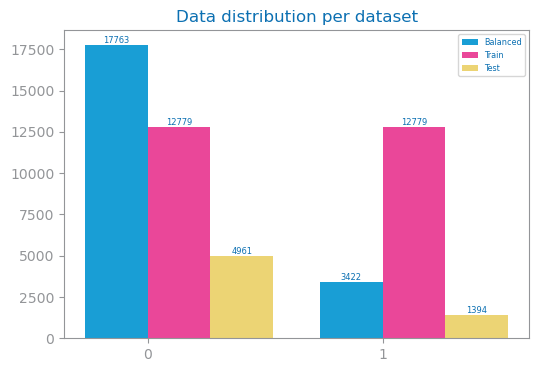

In [5]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Balanced": [
        len(df[df[target] == 0]),  # Assuming 0 is the negative class
        len(df[df[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# Model Evaluation Prep

## Evaluate for best model - RForests

In [6]:
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

Train#=25558 Test#=6355
Labels=[0, 1]


In [7]:

from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart
from matplotlib.pyplot import subplots, savefig, show, suptitle  # Importando diretamente suptitle


def random_forests_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
    file_tag=''
) -> tuple[RandomForestClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    max_features: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: RandomForestClassifier | None = None
    best_params: dict = {"name": "RF", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}

    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)

    suptitle(f"{file_tag} Random Forests study for {metric}")
    
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for f in max_features:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = RandomForestClassifier(
                    n_estimators=n, max_depth=d, max_features=f
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, f, n)
                    best_model = clf
                print(f'RF d={d} f={f} n={n}')
            values[f] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"RF max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'RF best for {best_params["params"][2]} trees (d={best_params["params"][0]} and f={best_params["params"][1]})'
    )
    return best_model, best_params


# f2 Model Evaluation

In [10]:
max_trees_eval=1000
max_trees_eval_lag=50

## f2 study

RF d=2 f=0.1 n=100
RF d=2 f=0.1 n=500
RF d=2 f=0.1 n=550
RF d=2 f=0.1 n=600
RF d=2 f=0.1 n=650
RF d=2 f=0.1 n=700
RF d=2 f=0.1 n=750
RF d=2 f=0.1 n=800
RF d=2 f=0.1 n=850
RF d=2 f=0.1 n=900
RF d=2 f=0.1 n=950
RF d=2 f=0.1 n=1000
RF d=2 f=0.3 n=100
RF d=2 f=0.3 n=500
RF d=2 f=0.3 n=550
RF d=2 f=0.3 n=600
RF d=2 f=0.3 n=650
RF d=2 f=0.3 n=700
RF d=2 f=0.3 n=750
RF d=2 f=0.3 n=800
RF d=2 f=0.3 n=850
RF d=2 f=0.3 n=900
RF d=2 f=0.3 n=950
RF d=2 f=0.3 n=1000
RF d=2 f=0.5 n=100
RF d=2 f=0.5 n=500
RF d=2 f=0.5 n=550
RF d=2 f=0.5 n=600
RF d=2 f=0.5 n=650
RF d=2 f=0.5 n=700
RF d=2 f=0.5 n=750
RF d=2 f=0.5 n=800
RF d=2 f=0.5 n=850
RF d=2 f=0.5 n=900
RF d=2 f=0.5 n=950
RF d=2 f=0.5 n=1000
RF d=2 f=0.7 n=100
RF d=2 f=0.7 n=500
RF d=2 f=0.7 n=550
RF d=2 f=0.7 n=600
RF d=2 f=0.7 n=650
RF d=2 f=0.7 n=700
RF d=2 f=0.7 n=750
RF d=2 f=0.7 n=800
RF d=2 f=0.7 n=850
RF d=2 f=0.7 n=900
RF d=2 f=0.7 n=950
RF d=2 f=0.7 n=1000
RF d=2 f=0.9 n=100
RF d=2 f=0.9 n=500
RF d=2 f=0.9 n=550
RF d=2 f=0.9 n=600
RF d=2 f

<Figure size 640x480 with 0 Axes>

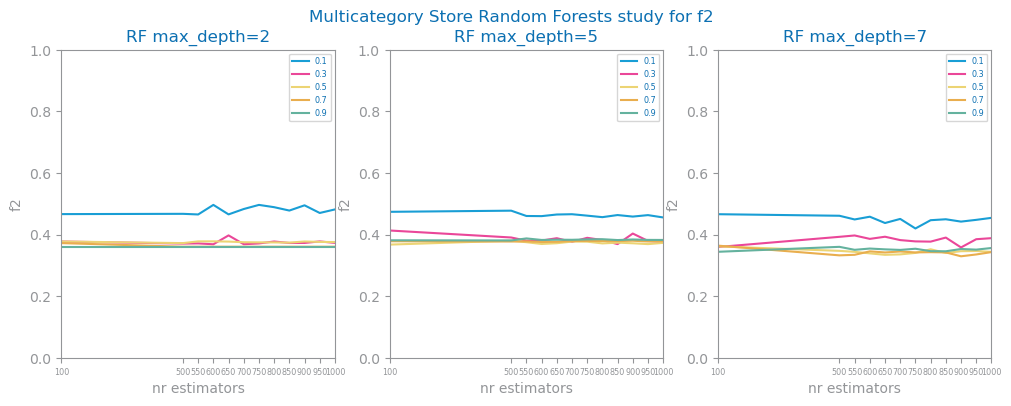

In [11]:
figure()

best_model_f2, f2_params = random_forests_study(
trnX,
trnY,
tstX,
tstY,
nr_max_trees=max_trees_eval,
lag=max_trees_eval_lag,
metric='f2',
file_tag=file_tag
)

savefig(f'images/{file_tag}_rf_{f2_params['metric']}_study.png')
show()
    

## f2 Best Model Performance

for max_eval=1000 and lag=50

<Figure size 640x480 with 0 Axes>

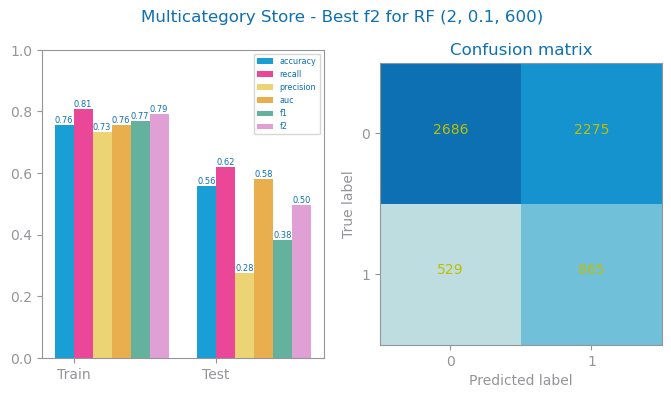

In [12]:
if evaluate == True:
    prd_trn: array = best_model_f2.predict(trnX)
    prd_tst: array = best_model_f2.predict(tstX)
    figure()
    plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
    savefig(f'images/{file_tag}_rf_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
    show()

## f2 Variables importance


1. day_of_week_cos (0.12428234406866828)
2. activity_in_session (0.12199989960437395)
3. day_of_week_sin (0.116631042209488)
4. day (0.11543198171931301)
5. hour_cos (0.10106918703281698)
6. hour_sin (0.08822953607547998)
7. product_category (0.07372994605202171)
8. category_code_lvl_2 (0.06407817000499716)
9. category_code_lvl_1 (0.05543193689619514)
10. week_of_month (0.05272292370448271)
11. brand_value (0.05022795563242823)
12. price (0.03616507699973469)


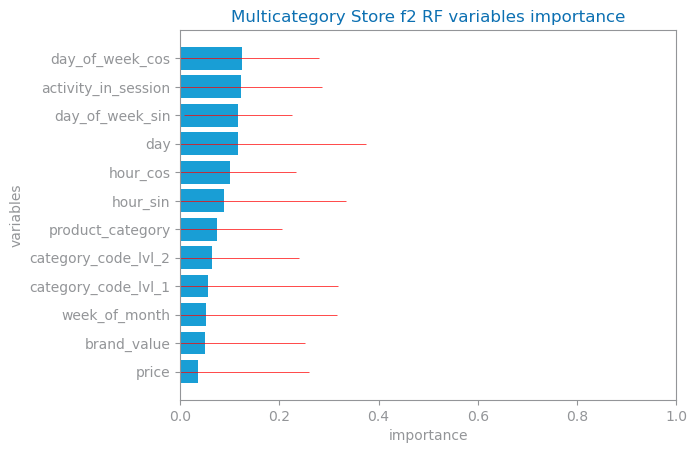

In [13]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model_f2.estimators_], axis=0)
)
importances = best_model_f2.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title=f"{file_tag} {f2_params["metric"]} RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{f2_params["metric"]}_vars_ranking.png")

## f2 Overfitting

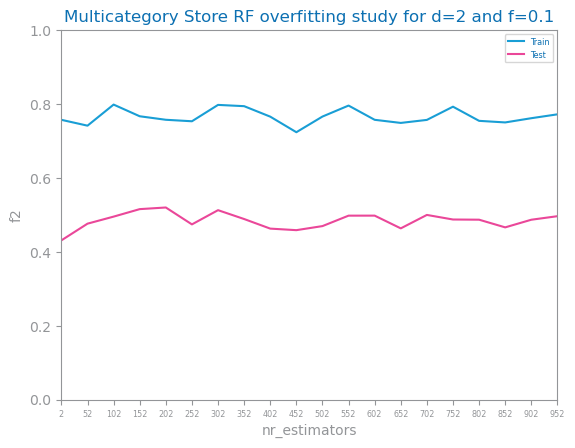

In [14]:
d_max: int = f2_params["params"][0]
feat: float = f2_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = f2_params["metric"]

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_overfitting.png")

# Precision Model Evaluation

In [19]:
max_trees_eval=700
max_trees_eval_lag=50

## precision study

RF d=2 f=0.1 n=100
RF d=2 f=0.1 n=500
RF d=2 f=0.1 n=550
RF d=2 f=0.1 n=600
RF d=2 f=0.1 n=650
RF d=2 f=0.1 n=700
RF d=2 f=0.3 n=100
RF d=2 f=0.3 n=500
RF d=2 f=0.3 n=550
RF d=2 f=0.3 n=600
RF d=2 f=0.3 n=650
RF d=2 f=0.3 n=700
RF d=2 f=0.5 n=100
RF d=2 f=0.5 n=500
RF d=2 f=0.5 n=550
RF d=2 f=0.5 n=600
RF d=2 f=0.5 n=650
RF d=2 f=0.5 n=700
RF d=2 f=0.7 n=100
RF d=2 f=0.7 n=500
RF d=2 f=0.7 n=550
RF d=2 f=0.7 n=600
RF d=2 f=0.7 n=650
RF d=2 f=0.7 n=700
RF d=2 f=0.9 n=100
RF d=2 f=0.9 n=500
RF d=2 f=0.9 n=550
RF d=2 f=0.9 n=600
RF d=2 f=0.9 n=650
RF d=2 f=0.9 n=700
RF d=5 f=0.1 n=100
RF d=5 f=0.1 n=500
RF d=5 f=0.1 n=550
RF d=5 f=0.1 n=600
RF d=5 f=0.1 n=650
RF d=5 f=0.1 n=700
RF d=5 f=0.3 n=100
RF d=5 f=0.3 n=500
RF d=5 f=0.3 n=550
RF d=5 f=0.3 n=600
RF d=5 f=0.3 n=650
RF d=5 f=0.3 n=700
RF d=5 f=0.5 n=100
RF d=5 f=0.5 n=500
RF d=5 f=0.5 n=550
RF d=5 f=0.5 n=600
RF d=5 f=0.5 n=650
RF d=5 f=0.5 n=700
RF d=5 f=0.7 n=100
RF d=5 f=0.7 n=500
RF d=5 f=0.7 n=550
RF d=5 f=0.7 n=600
RF d=5 f=0.7

<Figure size 640x480 with 0 Axes>

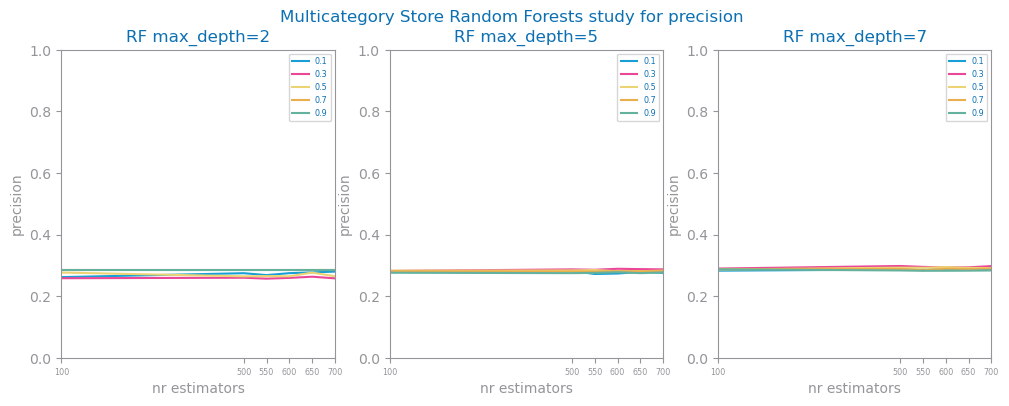

In [20]:
figure()

best_model_prec, prec_params = random_forests_study(
trnX,
trnY,
tstX,
tstY,
nr_max_trees=max_trees_eval,
lag=max_trees_eval_lag,
metric='precision',
file_tag=file_tag
)

savefig(f'images/{file_tag}_rf_{prec_params["metric"]}_study.png')
show()

## precision best model performance

max_trees_eval=700
max_trees_eval_lag=50

<Figure size 640x480 with 0 Axes>

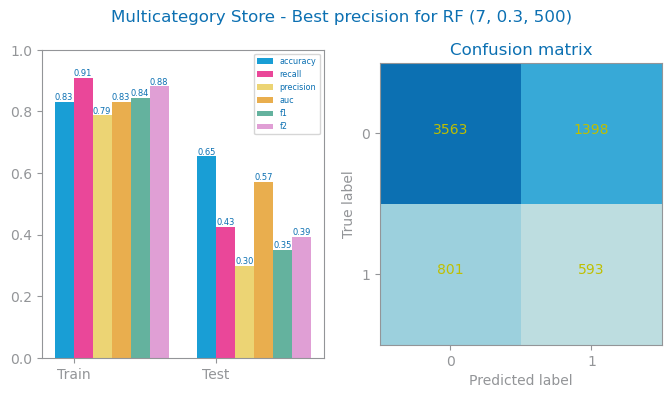

In [21]:
if evaluate == True:
    prd_trn: array = best_model_prec.predict(trnX)
    prd_tst: array = best_model_prec.predict(tstX)
    figure()
    plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels,file_tag=file_tag)
    savefig(f'images/{file_tag}_rf_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
    show()

## precision variables importance

1. activity_in_session (0.20970925634985596)
2. day_of_week_sin (0.15271825485657103)
3. day (0.1516179971052263)
4. day_of_week_cos (0.12819132861014837)
5. hour_cos (0.12319472255455576)
6. hour_sin (0.07394911219966417)
7. week_of_month (0.07023556145220847)
8. product_category (0.036464110014769305)
9. category_code_lvl_2 (0.02045701411278502)
10. price (0.012870934324834882)
11. brand_value (0.010981959430224711)
12. category_code_lvl_1 (0.009609748989155913)


<Axes: title={'center': 'Multicategory Store precision RF variables importance'}, xlabel='importance', ylabel='variables'>

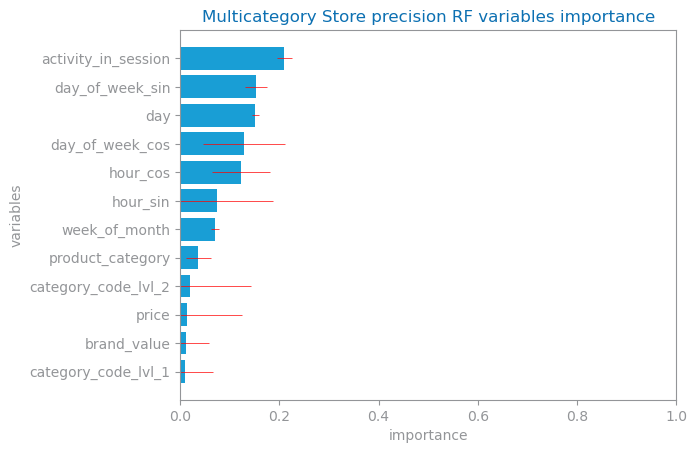

In [22]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model_prec.estimators_], axis=0)
)
importances = best_model_prec.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title=f"{file_tag} {prec_params["metric"]} RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)

## precision overfitting

<Axes: title={'center': 'Multicategory Store RF overfitting study for d=7 and f=0.3'}, xlabel='nr_estimators', ylabel='precision'>

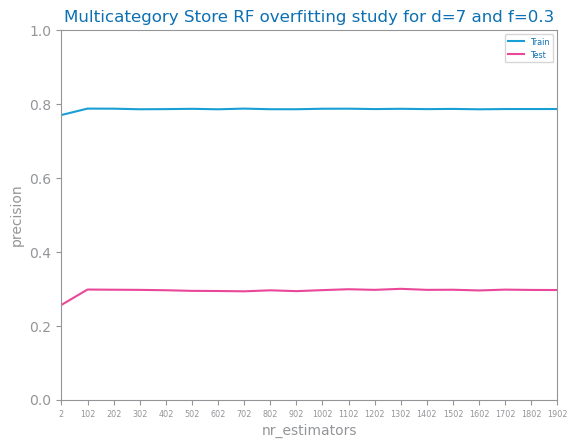

In [25]:
d_max: int = prec_params["params"][0]
feat: float = prec_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = prec_params["metric"]

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)

# Analysis

Precision/recall/ f2 study:
- recall KNN best with K=5
- Precision KNN best with  K=5
- f2 KNN best with K=3

# Analysis


We aim to achieve the minimum number of false positives while maintaining a high number of true positives. This enable us to effectively target customers who are likely to purchase (Tru positives). And This approach also helps reduce the budget spent on users we believed would buy but ultimately do not (False Positives).

Dataset used:
- Sample from balancing dataset was used, as running the evaluation on the with complete balancing dataset was too time-consuming.


Precision/recall/ f2 study:
- F2  best with (trees=600;d=2 and f=0.1)
- Precision best with (trees=500;d=7 and f=0.1)

- Multiple tree and depth configurations were tested to identify the best models for F2 and precision optimization. For F2, the best model had parameters (trees=600; d=2; f=0.1), achieving 62% recall and 28% precision on the test set. This high recall allows us to correctly identify 62% of true positives, but the lower precision and accuracy of 58% indicate a high rate of false positives.

- For the precision-optimized model, the best parameters (trees=500; d=7; f=0.1) involved fewer trees with greater depth, resulting in a notably higher precision of 30% (compared to 28% in the F2-optimized model) and 65% accuracy, though with a lower recall of 43%. This model, while capturing fewer true positives (lower recall), produces almost half as many false positives (higher precision). Given its better balance between true and false positives, we believe the precision-optimized model is more suitable for our dataset using random forests.

- In the precision model, the variables day_of_week_sin, activity_in_session, and day are the most relevant. Compared to the decision tree algorithm, the most relevant variables are nearly the same, but in random forests, this relevancy is more evenly spread across these variables.

- Overfitting: In general, random forests are less prone to overfitting, which holds true for both F2 and precision models in our case. For precision, there is minimal variation in precision as the number of estimators increases. For F2, precision variations in the training and test sets are similar, confirming no overfitting.



For f2, these are the most relevant values:
1. day_of_week_cos (0.12)
2. activity_in_session (0.121)
3. day_of_week_sin (0.116)
4. day (0.115)
5. hour_cos (0.10)
6. hour_sin (0.08)
7. product_category (0.073)
8. category_code_lvl_2 (0.064)
9. category_code_lvl_1 (0.055)
10. week_of_month (0.052)
11. brand_value (0.0502)
12. price (0.036)


For precision:
1. activity_in_session (0.20)
2. day_of_week_sin (0.15)
3. day (0.151)
4. day_of_week_cos (0.128)
5. hour_cos (0.123)
6. hour_sin (0.073)
7. week_of_month (0.070)
8. product_category (0.036)
9. category_code_lvl_2 (0.020)
10. price (0.012)
11. brand_value (0.010)
12. category_code_lvl_1 (0.009)

## Extended analysis

- Multiple tree and depth configurations were tested to identify the best models for F2 and precision optimization. For F2, the best model had parameters (trees=600; d=2; f=0.1), achieving 62% recall and 28% precision on the test set. This high recall allows us to correctly identify 62% of true positives, but the lower precision and accuracy of 58% indicate a high rate of false positives.

- For the precision-optimized model, the best parameters (trees=500; d=7; f=0.1) involved fewer trees with greater depth, resulting in a notably higher precision of 30% (compared to 28% in the F2-optimized model) and 65% accuracy, though with a lower recall of 43%. This model, while capturing fewer true positives (lower recall), produces almost half as many false positives (higher precision). Given its better balance between true and false positives, we believe the precision-optimized model is more suitable for our dataset using random forests.

- In the precision model, the variables day_of_week_sin, activity_in_session, and day are the most relevant. Compared to the decision tree algorithm, the most relevant variables are nearly the same, but in random forests, this relevancy is more evenly spread across these variables.

- Overfitting: In general, random forests are less prone to overfitting, which holds true for both F2 and precision models in our case. For precision, there is minimal variation in precision as the number of estimators increases. For F2, precision variations in the training and test sets are similar, confirming no overfitting.

## Short analysis for the report:
- Best F2 model (trees=600; d=2) had 62% recall, 28% precision. Precision model (trees=500; d=7) achieved 30% precision, 65% accuracy. Precision model suits our dataset, balancing true and false positives better. No overfitting.